In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

# Set plot style
sns.set_theme(style="whitegrid")

In [4]:
# ============================================================
# 1️⃣ Load and preprocess dataset
# ============================================================
# Make sure "Salary Data 14.xlsx" is in the same folder.
# If it's a CSV, change to pd.read_csv("filename.csv")
filename = "Salary Data 14.csv"

try:
    # Try reading as Excel first
    df = pd.read_excel(filename)
    print("✅ Dataset loaded successfully (Excel format).")
except Exception as e_xls:
    try:
        # Fallback to CSV if Excel fails
        df = pd.read_csv(filename.replace(".xlsx", ".csv"))
        print("✅ Dataset loaded successfully (CSV format).")
    except Exception as e_csv:
        print(f"❌ Error: Could not load file '{filename}'.")
        print(f"Excel Error: {e_xls}")
        print(f"CSV Error: {e_csv}")

if 'df' in locals():
    # Remove rows with missing values
    df = df.dropna()
    
    print("\nFirst 5 rows of data:")
    display(df.head())

    # --- Feature Engineering ---
    # 1. Years of Experience (Numeric)
    X1 = df["Years of Experience"].values

    # 2. Education Level (Categorical -> Numeric Mapping)
    # Standardize the text first to handle variations like "Bachelor's" vs "Bachelor"
    df["Education Level"] = df["Education Level"].astype(str).str.strip().str.title()
    
    edu_mapping = {
        "High School": 0,
        "Bachelor'S": 1, "Bachelor": 1,
        "Master'S": 2, "Master": 2,
        "Phd": 3
    }
    # Use list comprehension for mapping, default to 0 if unknown
    X2 = np.array([edu_mapping.get(val, 0) for val in df["Education Level"]])

    # 3. Job Title (Categorical -> Numeric Encoding)
    # Using cat.codes is a simple way to turn text categories into numbers 0, 1, 2...
    X3 = df["Job Title"].astype("category").cat.codes.values

    # Target Variable
    y = df["Salary"].values

    # --- Feature Normalization (Standard Scaling) ---
    # Crucial for Gradient Descent to converge smoothly
    X1 = (X1 - np.mean(X1)) / np.std(X1)
    X2 = (X2 - np.mean(X2)) / np.std(X2)
    X3 = (X3 - np.mean(X3)) / np.std(X3)
    
    print("\nData Preprocessing Complete.")
    print(f"Total samples: {len(y)}")

✅ Dataset loaded successfully (CSV format).

First 5 rows of data:


,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0



Data Preprocessing Complete.
Total samples: 373


In [5]:
# ============================================================
# 2️⃣ Hyperparameters
# ============================================================
alpha = 0.01      # Learning rate (step size)
epochs = 1500     # Number of training iterations (increased slightly for better convergence)
k_folds = 5       # Number of folds for cross-validation

# Initialize K-Fold splitter
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

print(f"Setup: {k_folds}-Fold CV, Learning Rate={alpha}, Epochs={epochs}")

Setup: 5-Fold CV, Learning Rate=0.01, Epochs=1500


In [6]:
if 'X1' in locals():
    print("Starting K-Fold Cross-Validation Training...\n")
    
    fold = 1
    mse_scores = []
    r2_scores = []
    cost_history_all = []

    # Loop through each fold generated by KFold
    for train_index, test_index in kf.split(X1):
        print(f"🔹 Fold {fold}/{k_folds}...")

        # --- 1. Split data for this fold ---
        X1_train, X1_test = X1[train_index], X1[test_index]
        X2_train, X2_test = X2[train_index], X2[test_index]
        X3_train, X3_test = X3[train_index], X3[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # --- 2. Initialize model parameters ---
        m1 = m2 = m3 = c = 0.0
        n_train = len(y_train)
        cost_history = []

        # --- 3. Gradient Descent Training ---
        for i in range(epochs):
            # Forward pass: Predict salaries
            y_pred = m1 * X1_train + m2 * X2_train + m3 * X3_train + c

            # Calculate error
            error = y_pred - y_train

            # Calculate cost (MSE / 2) for monitoring
            cost = (1 / (2 * n_train)) * np.sum(error ** 2)
            cost_history.append(cost)

            # Backward pass: Calculate gradients
            dm1 = (1 / n_train) * np.sum(error * X1_train)
            dm2 = (1 / n_train) * np.sum(error * X2_train)
            dm3 = (1 / n_train) * np.sum(error * X3_train)
            dc = (1 / n_train) * np.sum(error)

            # Update weights
            m1 -= alpha * dm1
            m2 -= alpha * dm2
            m3 -= alpha * dm3
            c -= alpha * dc

        # Store cost history for plotting later
        cost_history_all.append(cost_history)

        # --- 4. Evaluate on Test Data for this fold ---
        y_pred_test = m1 * X1_test + m2 * X2_test + m3 * X3_test + c

        # Calculate Metrics
        mse = np.mean((y_pred_test - y_test) ** 2)
        
        ss_total = np.sum((y_test - np.mean(y_test)) ** 2)
        ss_residual = np.sum((y_test - y_pred_test) ** 2)
        r2 = 1 - (ss_residual / ss_total)

        mse_scores.append(mse)
        r2_scores.append(r2)

        print(f"   -> MSE: {mse:,.2f}")
        print(f"   -> R² Score: {r2*100:.2f}%")
        fold += 1

    print("\nTraining complete.")

Starting K-Fold Cross-Validation Training...

🔹 Fold 1/5...
   -> MSE: 255,660,404.24
   -> R² Score: 89.34%
🔹 Fold 2/5...
   -> MSE: 261,569,291.82
   -> R² Score: 86.18%
🔹 Fold 3/5...
   -> MSE: 250,547,029.78
   -> R² Score: 89.43%
🔹 Fold 4/5...
   -> MSE: 247,502,530.58
   -> R² Score: 89.79%
🔹 Fold 5/5...
   -> MSE: 347,339,947.87
   -> R² Score: 85.87%

Training complete.


In [7]:
if 'mse_scores' in locals() and len(mse_scores) > 0:
    print("=======================================")
    print("✅ Final Cross-Validation Results")
    print("=======================================")
    print(f"Average MSE:      {np.mean(mse_scores):,.2f}")
    print(f"Average R² Score: {np.mean(r2_scores) * 100:.2f}%")
    
    # std deviation gives an idea of how stable the model is across different data splits
    print(f"R² Standard Deviation: {np.std(r2_scores) * 100:.2f}%")

✅ Final Cross-Validation Results
Average MSE:      272,523,840.86
Average R² Score: 88.12%
R² Standard Deviation: 1.72%


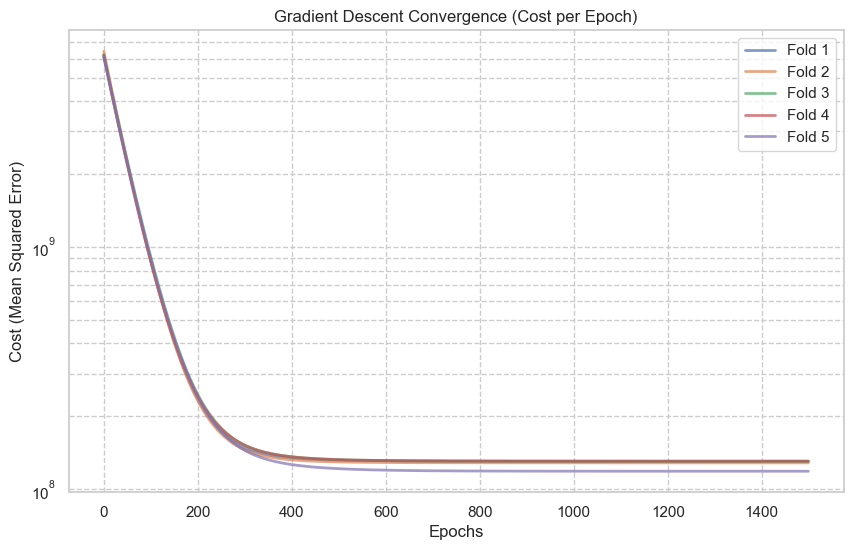

In [8]:
if 'cost_history_all' in locals() and len(cost_history_all) > 0:
    # Plot Cost Function for all folds to check convergence
    plt.figure(figsize=(10, 6))
    for i, history in enumerate(cost_history_all):
        plt.plot(history, linewidth=2, alpha=0.7, label=f'Fold {i+1}')
    
    plt.title("Gradient Descent Convergence (Cost per Epoch)")
    plt.xlabel("Epochs")
    plt.ylabel("Cost (Mean Squared Error)")
    plt.legend()
    plt.yscale('log') # Log scale can sometimes show convergence better if cost drops fast
    plt.grid(True, which="both", ls="--")
    plt.show()

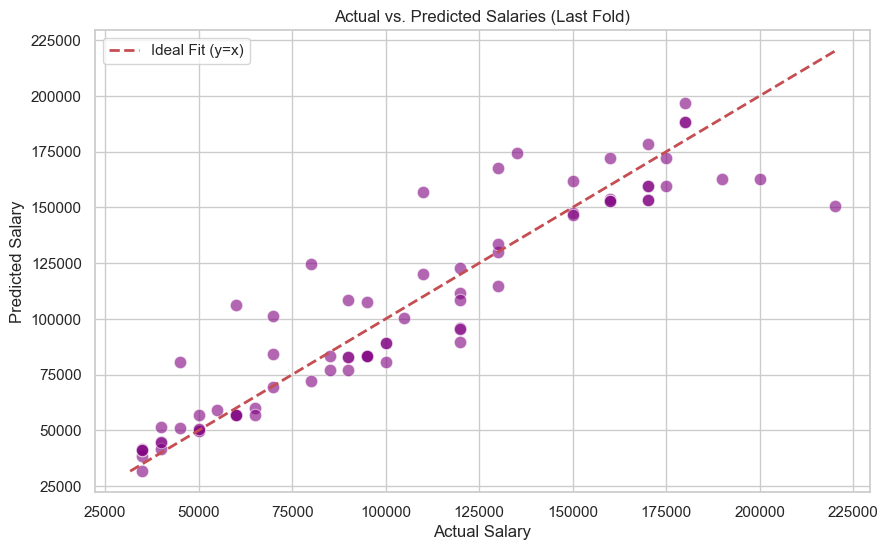

In [9]:
if 'y_test' in locals() and 'y_pred_test' in locals():
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.6, s=80, color='purple')
    
    # Perfect prediction line
    min_val = min(np.min(y_test), np.min(y_pred_test))
    max_val = max(np.max(y_test), np.max(y_pred_test))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Ideal Fit (y=x)')
    
    plt.title("Actual vs. Predicted Salaries (Last Fold)")
    plt.xlabel("Actual Salary")
    plt.ylabel("Predicted Salary")
    plt.legend()
    plt.show()